In [1]:
load("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/scripts/pks/Nissle_processed.RData")

In [2]:
library(tidyverse)
library(reshape2)
library(magrittr)
library(lemon)
library(BSgenome)
library(MutationalPatterns)
library(plyr)
library(data.table)
library(vroom)
library(ggpubr)
library(cowplot)
library(patchwork)
library(BSgenome.Hsapiens.UCSC.hg38)
library(TxDb.Hsapiens.UCSC.hg38.knownGene)
library(sjPlot)
library(ggseqlogo)
library(ggplot2)
library(gtools)
library(ggh4x)
library(ggridges)
library(dtplyr)
library(ggpp)
library(geomtextpath)

ref_genome = "BSgenome.Hsapiens.UCSC.hg38"
genes = genes(TxDb.Hsapiens.UCSC.hg38.knownGene)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths



Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract


Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following object is masked from ‘package:lubridate’:

    as.difftime


The following object

In [3]:
plot_indel_contexts2 = function (counts, same_y = FALSE, extra_labels = FALSE, condensed = FALSE)
{


  INDEL_COLORS <- c(
    "#FDBE6F", "#FF8001", "#B0DD8B", "#36A12E", "#FDCAB5", "#FC8A6A",
    "#F14432", "#BC141A", "#D0E1F2", "#94C4DF", "#4A98C9", "#1764AB",
    "#E2E2EF", "#B6B6D8", "#8683BD", "#61409B"
  )


  count <- muttype <- muttype_sub <- muttype_total <- sample <- NULL
  counts <- counts %>% as.data.frame() %>% tibble::rownames_to_column("muttype_total") %>%
    tidyr::separate(muttype_total, c("muttype", "muttype_sub"),
                    sep = "_(?=[0-9])") %>% dplyr::mutate(muttype = factor(muttype,
                                                                           levels = unique(muttype))) %>% tidyr::gather(key = "sample",
                                                                                                                        value = "count", -muttype, -muttype_sub) %>% dplyr::mutate(sample = factor(sample,
                                                                                                                                                                                                   levels = unique(sample)))
  nr_muts <- counts %>% dplyr::group_by(sample) %>% dplyr::summarise(nr_muts = round(sum(count)))
  facet_labs_y <- nr_muts$sample
  names(facet_labs_y) <- nr_muts$sample
  facet_labs_x <- c("1: C", "1: T", "1: C", "1: T", 2, 3, 4,
                    "5+", 2, 3, 4, "5+", 2, 3, 4, "5+")
  names(facet_labs_x) <- levels(counts$muttype)
  if (same_y) {
    facet_scale <- "free_x"
  }
  else {
    facet_scale <- "free"
  }
  if (extra_labels) {
    title <- stringr::str_c("Deletion           ", "Insertion          ",
                            "Deletion                                   ", "Insertion                                  ",
                            "Deletion (MH)")
    x_lab <- stringr::str_c("Homopolymer length                            ",
                            "Number of repeat units                                                                               ",
                            "Microhomology length")
  }
  else {
    title <- x_lab <- ""
  }
  if (condensed == TRUE) {
    width <- 1
    spacing <- 0
  }
  else {
    width <- 0.6
    spacing <- 0.5
  }
  fig <- ggplot(counts, aes(x = muttype_sub, y = count, fill = muttype,
                            width = width)) + geom_bar(stat = "identity") + facet_grid(sample ~
                                                                                         muttype, scales = facet_scale, space = "free_x", labeller = labeller(muttype = facet_labs_x,
                                                                                                                                                              sample = facet_labs_y)) + scale_fill_manual(values = INDEL_COLORS) +
    theme_bw() + labs(fill = "Mutation type", title = title,
                      y = "Nr of indels", x = x_lab) + theme(panel.grid.major.x = element_blank(),
                                                             panel.grid.minor.y = element_blank(), panel.spacing.x = unit(spacing,
                                                                                                                          "lines"))
  return(fig)
}

In [3]:
get_context = function(gr, size_context = 10){
  gr = gr[gr$FILTER == "PASS"]
  gr = gr[which(nchar(gr$REF) == 1 )]
  strand = ifelse(gr$REF == "G" | gr$REF == "A", '-', "+")
  start = start(gr)
  ref = as.character(gr$REF)
  alt = unlist(CharacterList(gr$ALT))
  type = paste0(ref, ">", alt)
  chromosome = as.character(seqnames(gr))
  context = getSeq(Hsapiens, chromosome,  start = start - size_context,
                   end =  start + size_context,
                   strand = strand)

  type = mapvalues(type, c("A>C","A>G","A>T","G>C", "G>A","G>T"),
                   c("T>G", "T>C", "T>A", "C>G", "C>T", "C>A"), warn_missing	= FALSE)
  trinucleotide = paste0(substr(context, 10, 10), "[", type, "]", substr(context, 12,12))


  context_table = tibble(chr = chromosome, position = start, type = type, strand = strand,
                         context = as.character(context), trinucleotide = trinucleotide)
  context_table$id = paste0(context_table$chr, "_", context_table$position, "_", context_table$type)
  return(context_table)
}

In [15]:
gb_map <- list(
  GB19 = list(crypt = c("C22_19_SI", "D4_19_TR"), blood = "GIB-019"),
  GB9  = list(crypt = c("A9_09_CE", "B29_09_AS", "D2_09_TR"), blood = "GIB-09"),
  GB130 = list(crypt = c("24_130DC","30_130RE","33_130AS","B35_130_TR","D17_130_CE"), blood = "GIB-130"),
  GB180 = list(crypt = c("23_180RE","A15__180_TR","A10__180_DC","B38_180_SI","B12_180_AS","C16_180_CE"), blood = "GIB-180"),
  GB93 = list(crypt = c("A8__093_SI","B22_93_TR","B32_93_AS","C17_93_AS","C10_93_CE","D24_093_RE"), blood = "GIB-93"),
  GB74 = list(crypt = c("74_DC","29_74TR","A5__074_AS","D14_074_RE","D27_074_SI"), blood = "GIB-74"),
  GB76 = list(crypt = c("D32_076_CE","22_76TR","B4_076_SI","D13_076_RE","D8_076_AS","D33_076_DE"), blood = "GIB-76"),
  GB31 = list(crypt = c("031_RE_T","A1__031_AS","B14_031_CE","B5_031_RE","B28_31_TR","C24_31_TR","D31_031_DE"), blood = "GIB-031"),
  GB30 = list(crypt = c("030_CE_T","30_TR","B7_030_DC","D10_030_RE","D29_030_AS"), blood = "GIB-030"),
  GB58 = list(crypt = c("058_RE_T","58_TR","58_DC","B10_058_CE","D12_058_SI"), blood = "GIB-58"),
  GB84 = list(crypt = c("A16__084_CE","B3_084_DC","D6_84_RE","D26_084_SI","D9_084_AS","12b_D12_84_TR"), blood = "GIB-84"),
  GB27 = list(crypt = c("27_CE","27_DC","19_27TR","17_27AS","18_27RE"), blood = "GIB-027"),
  GB29 = list(crypt = c("29_CE","029_DC_T","32_29TR","D25_029_RE","D30_029_AS"), blood = "GIB-029"),
  GB103 = list(crypt = c("103_RE","A6__103_CE","B8_103_SI","C1_103_TR","C3_103_DE"), blood = "GIB-103"),
  GB116 = list(crypt = c("B27_116_AS","116_TR","116_RE_T","21_116CE","A7__116_DC","B2_116_RE"), blood = "GIB-116"),
  GB148 = list(crypt = c("148_SI","A2__148_CE","A13__148_AS","B13_148_DC","B15_148_RE","C5_148_TR"), blood = "GIB-148"),
  GB40 = list(crypt = c("40_AS","20_40DC","D7_40_RE","D16_040_SI"), blood = "GIB-040"),
  GB115 = list(crypt = c("Laurel-2","Laurel-10","B1_115_SI","B9_115_RE","B26_115_DC","B18_115_TC","C14_115_TR",
                         "Laurel-1","Laurel-3","Laurel-5","Laurel-6","Laurel-7","Laurel-8","Laurel-11","Laurel-12"),
                blood = "GIB-115"),
  GB273 = list(crypt = c("B43_273_AS","B44_273_TR","B45_273_SI","B46_273_DE","B47_273_RE","B20_273_CE"), blood = NA_character_),
  GB153 = list(crypt = c("B21_153_CE","B33_153_AS","B6_153_SI","B23_153_RE","C6_153_RE","D11_153_DE","D18_153_TR","D20_153_SI"), blood = NA_character_),
  GB277 = list(crypt = c("B41_277_AC","B39_277_CE","B42_277_RTM","B17_277_DC","B19_277_TC","C15_277_TR","C18_277_DE","D15_277_SI","D15b_277_SI"), blood = "GIB-277"),
  O300 = list(crypt = c("PD37509b8","PD37509b9"), blood = NA_character_),
  O312 = list(crypt = c("PD37510b4","PD37510b7","PD37510b8"), blood = NA_character_),
  HLS  = list(crypt = c("HLS_1C_30_B5","HLS_1C_30_D5","HLS_1C_30_G5","HLS_1C_30_H5",
                        "HLS_2C_30_D6","HLS_2C_30_E6"), blood = NA_character_),
  O132 = list(crypt = c("PD36813h3","PD36813h5","PD36813h","PD36813r12",
                        "PD36813r14","PD36813u2"), blood = NA_character_),
  O162 = list(crypt = c("PD36813g2","PD36813g4","PD36813s12","PD36813v4"), blood = NA_character_),
  O174 = list(crypt = c("PD36814e5","PD36814e6","PD36814e7","PD36814e8",
                        "PD37226d4","PD37226d5","PD37226d6","PD37265e5","PD37265e"), blood = NA_character_),
  O176 = list(crypt = c("PD36814f4","PD36814f8","PD37226e4","PD37226e5",
                        "PD37265f2","PD37265f4","PD37265f"), blood = NA_character_),
  O187 = list(crypt = c("PD36813e5","PD36813e6","PD36813e",
                        "PD36813t20","PD36813x15","PD36813x16"), blood = NA_character_),
  O189 = list(crypt = c("PD36813ad17","PD36813ad2","PD36813ad8",
                        "PD36813ad9","PD36813d3","PD36813d5"), blood = NA_character_),
  O193 = list(crypt = c("PD36814g4","PD36814g7","PD36814g8",
                        "PD37226f5","PD37226f6","PD37226f7",
                        "PD37265g6","PD37265g7","PD37265g8"), blood = NA_character_),
  O208 = list(crypt = c("PD36813ae3","PD36813ae7","PD36813ae",
                        "PD36813c2","PD36813c3","PD36813c"), blood = NA_character_),
  O225 = list(crypt = c("PD36814h2","PD36814h4","PD37226g5",
                        "PD37226g6","PD37226g7",
                        "PD37265h5","PD37265h6","PD37265h8"), blood = NA_character_),
  O232 = list(crypt = c("PD36814i3","PD36814i4","PD36814i",
                        "PD37226h4","PD37226h7","PD37226h8",
                        "PD37265i2","PD37265i7"), blood = NA_character_),
  O244 = list(crypt = c("PD36814k2","PD36814k6","PD36814k7",
                        "PD36814k8","PD37265k2","PD37265k3","PD37265k"), blood = NA_character_),
  O251 = list(crypt = c("PD36813ac15","PD36813ac18","PD36813ac2",
                        "PD36813ac4","PD36813ac7",
                        "PD36813b4","PD36813b5","PD36813b6"), blood = NA_character_),
  O311 = list(crypt = c("PD37512a11","PD37512a4","PD37512a5","PD37512b7"), blood = NA_character_),
  O325 = list(crypt = c("PD37513a13","PD37513a20","PD37513a21","PD37513a2",
                        "PD37513a3","PD37513b5","PD37513b7","PD37513b8"), blood = NA_character_),
  O333 = list(crypt = c("PD36814l2","PD36814l4","PD36814l7","PD36814l8",
                        "PD37226i5","PD37226i6","PD37226i7","PD37226i8",
                        "PD37265l2","PD37265l6"), blood = NA_character_),
  O337 = list(crypt = c("PD36814m5","PD36814m8","PD37226j4","PD37226j5",
                        "PD37226j6","PD37226j7","PD37226j8",
                        "PD37226o4","PD37226o5","PD37226p7",
                        "PD37265m3","PD37265m4"), blood = NA_character_),
  O340 = list(crypt = c("PD37226k2","PD37226k5","PD37226k6","PD37226k8",
                        "PD37457e6","PD37457f4","PD37457f7"), blood = NA_character_),
  O342 = list(crypt = c("PD37514a2","PD37514a3","PD37514a",
                        "PD37514b3","PD37514b7","PD37514b8"), blood = NA_character_),
  O395 = list(crypt = c("PD37226l5","PD37226l6","PD37226l7","PD37226l8",
                        "PD37457b4","PD37457g5"), blood = NA_character_),
  O401 = list(crypt = c("PD37226m5","PD37226m7","PD37226m8",
                        "PD37457c4","PD37457h2","PD37457h5"), blood = NA_character_),
  O438 = list(crypt = c("PD37457i4","PD37457i5","PD37457j7","PD37457j8"), blood = NA_character_),
  OO10 = list(crypt = c("PD36814d5","PD36814d6","PD36814d7","PD36814d8",
                         "PD37226c5","PD37226c6","PD37226c7","PD37226c8",
                         "PD37265d5","PD37265d8","PD37265d"), blood = NA_character_),
  OO13 = list(crypt = c("PD36719a_lo005","PD36719a_lo008","PD36719a_lo018",
                         "PD36719a_lo022","PD36719a_lo034","PD36719a_lo048",
                         "PD36719a_lo049","PD36719a_lo066","PD36719a_lo072"), blood = NA_character_),
  OO23 = list(crypt = c("PD36813m3","PD36813m5","PD36813m8","PD36813n"), blood = NA_character_),
  OO35 = list(crypt = c("PD36813l7","PD36813l8","PD36813l"), blood = NA_character_),
  OO39 = list(crypt = c("PD36813y13","PD36813y15","PD36813y6","PD36813y7"), blood = NA_character_),
  OO82 = list(crypt = c("PD36813k3","PD36813k5","PD36813k",
                         "PD36813o2","PD36813o9",
                         "PD36813z15","PD36813z4","PD36813z5",
                         "PD36813z6","PD36813z7","PD36813z8"), blood = NA_character_),
  OO94 = list(crypt = c("PD36813aa11","PD36813aa12","PD36813aa16",
                         "PD36813aa2","PD36813aa7","PD36813aa",
                         "PD36813j3","PD36813j6","PD36813j","PD36813p"), blood = NA_character_),
  OO99 = list(crypt = c("PD36813ab10","PD36813ab4","PD36813ab5",
                         "PD36813i4","PD36813i6","PD36813i",
                         "PD36813q11","PD36813q14"), blood = NA_character_),
  OOO7 = list(crypt = c("PD36814b2","PD36814b7","PD37265b7","PD37265b"), blood = NA_character_),
  OOO8 = list(crypt = c("PD36814c2","PD36814c3","PD36814c4",
                         "PD37226b5","PD37226b6",
                         "PD37265c2","PD37265c3","PD37265c5"), blood = NA_character_),
  PD28690 = list(crypt = c("PD28690bx_2_a5", "PD28690bx_2_d5", "PD28690cb_2_g1", "PD28690cb_2_g3","PD28690cb_2_h1", "PD28690cb_2_h3"), blood = NA_character_),
  PD37590 = list(crypt = c("PD37590b_lo0010", "PD37590b_lo0015", "PD37590b_lo0018", "PD37590b_lo0030", "PD37590b_lo0033","PD37590b_lo0041", "PD37590b_lo0051", "PD37590b_lo0052", "PD37590b_lo0053", "PD37590b_lo0058",
  "PD37590b_lo0074",
      "PD37590b_lo0075",
      "PD37590b_lo0090",
      "PD37590b_lo0092",
      "PD37590b_lo0107",
      "PD37590b_lo0116",
      "PD37590b_lo0117",
      "PD37590c_lo0001",
      "PD37590c_lo0005",
      "PD37590c_lo0009",
      "PD37590c_lo0019",
      "PD37590c_lo0021",
      "PD37590c_lo0025",
      "PD37590c_lo0032",
      "PD37590c_lo0034",
      "PD37590c_lo0040",
      "PD37590c_lo0048",
      "PD37590d_lo0012"), blood = NA_character_),
PD34199 = list(crypt = c("PD34199a_c22", "PD34199a_c27", "PD34199a_c28", "PD34199a_c31", "PD34199a_c3", "PD34199a_c5", "PD34199a_c7", "PD34199a_s13",
                         "PD34199a_s16", "PD34199a_s27","PD34199a_s2", "PD34199a_s31", "PD34199a_s4", "PD34199a_t14","PD34199a_t16","PD34199a_t18",
                         "PD34199a_t22","PD34199a_t24","PD34199a_t28", "PD34199a_t31", "PD34199a_c17"), blood = NA_character_),
PD34202 = list(crypt = c("PD34202a_s41", "PD34202a_s9", "PD34202a_s27","PD34202a_s15","PD34202a_s12","PD34202a_s43"), blood = NA_character_),
PD37449 = list(crypt = c("PD37449c_lo0001","PD37449c_lo0009","PD37449c_lo0014","PD37449c_lo0017","PD37449d_lo0001","PD37449d_lo0002","PD37449d_lo0003",
"PD37449d_lo0006",
      "PD37449d_lo0011",
      "PD37449d_lo0012",
      "PD37449d_lo0017",
      "PD37449e_lo0001",
      "PD37449e_lo0002",
      "PD37449e_lo0003",
      "PD37449e_lo0004",
      "PD37449e_lo0006",
      "PD37449e_lo0008",
      "PD37449e_lo0010",
      "PD37449e_lo0014",
      "PD37449e_lo0015",
      "PD37449f_lo0002",
      "PD37449f_lo0006",
      "PD37449f_lo0008",
      "PD37449f_lo0010",
      "PD37449f_lo0011",
      "PD37449f_lo0016",
      "PD37449f_lo0017",
      "PD37449f_lo0019",
      "PD37449f_lo0022",
      "PD37449f_lo0023"), blood = NA_character_),
PD37266 = list(crypt = c("PD37266b_lo0004",
      "PD37266b_lo0005",
      "PD37266b_lo0006",
      "PD37266b_lo0007",
      "PD37266b_lo0008",
      "PD37266b_lo0017",
      "PD37266b_lo0023",
      "PD37266c_lo0010",
      "PD37266c_lo0012",
      "PD37266c_lo0014",
      "PD37266c_lo0016",
      "PD37266c_lo0018",
      "PD37266c_lo0023",
      "PD37266d_lo0002",
      "PD37266d_lo0010",
      "PD37266d_lo0012",
      "PD37266d_lo0014",
      "PD37266e_lo0008",
      "PD37266e_lo0010"), blood = NA_character_)
)

In [16]:
# --2) cohorts (GB-level) as you provided ---
cohort_gbs <- list(
  normal = c("GB9","GB40","GB103","GB130","GB180","GB58","GB27","GB148","GB153","GB273","GB277","O312","PD34202","O300","PD37449", "PD37590",
              "O187","HLS","OO13", "O189","O342","O325","OO82","OO94", "OO35","OO99","OO23","PD37266","O132","PD34199","O311","O208","OO39",
               "O251","O162","PD28690"),
  adenoma = c("GB19","GB31","GB30","GB76","GB115","GB116","GB29","GB74","GB84","GB93"),
  carcinoma = c("O395","OO10","O438","O232","O401","OOO7","OOO8","O174","O337","O225","O244","O333","O176","O193","O340")
)

# --3) expand cohorts to sample-level (collect crypt_samples for each cohort) ---
cohort_samples <- lapply(cohort_gbs, function(gbs) {
  unique(unlist(lapply(gbs, function(gb) {
    if (!is.null(gb_map[[gb]])) gb_map[[gb]]$crypt else character(0)
  })))
})


Input the vcfs (SNVs and INDELs)

In [12]:
vcf_files =  list.files("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/snvs_all/input", recursive = T, full.names = T, pattern = "\\.vcf")
names(vcf_files) <- basename(vcf_files)
names(vcf_files) <- gsub("\\.nuclear_all\\.intersection\\.vcf$", "", names(vcf_files))

In [13]:
vcf_indel_files = list.files("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/output/CellCut/overlap_variants/indels_all/input", full.names = T)
names(vcf_indel_files) <- basename(vcf_indel_files)
names(vcf_indel_files) <- gsub("\\.nuclear_all_indels\\.intersection\\.vcf$", "", names(vcf_indel_files))

In [14]:
vcfs = read_vcfs_as_granges(vcf_files, names(vcf_files), genome =  ref_genome, type = "all")
vcfs_sbs = get_mut_type(vcfs, "snv")


Any neighbouring SNVs will be merged into DBS/MBS variants.
Set the 'predefined_dbs_mbs' to 'TRUE' if you don't want this.



In [15]:
vcfs_indel = read_vcfs_as_granges(vcf_indel_files, names(vcf_indel_files), ref_genome, type = "indel")
vcfs_indel = get_mut_type(vcfs_indel, "indel")

In [5]:
mut_mat = mut_matrix(vcfs_sbs, ref_genome)
mut_mat_s = mut_matrix_stranded(vcfs_sbs, ref_genome, genes)

In [17]:
norm_variants <- function(x) {
  x <- trimws(as.character(x))
  unique(c(x, gsub("\\.", "_", x), gsub("_", ".", x)))
}

cat_names <- colnames(mut_mat)
categories_vec <- rep(NA_character_, length(cat_names))

for (cohort in names(cohort_samples)) {
  lookup <- unique(unlist(lapply(cohort_samples[[cohort]], norm_variants)))
  matches <- vapply(cat_names, function(nm) any(norm_variants(nm) %in% lookup), logical(1))
  categories_vec[matches] <- cohort
}
categories <- data.table(injection = categories_vec)
categories[, name := colnames(mut_mat)]
categories[, method := ifelse(grepl("NISL", name), "PTA", "Crypt")]

# make injection a factor with levels you want (only normal and adenoma)
categories$injection <- factor(categories$injection, levels = c("normal", "adenoma", "carcinoma"))

# optional: warn about unmatched samples
if (any(is.na(categories$injection))) {
  warning(sprintf("There are %d samples unmatched to clinical cohort. They will have NA in categories$injection.",
                  sum(is.na(categories$injection))))
}


In [13]:
#categories[is.na(categories$injection)]

injection,name,method
<fct>,<chr>,<chr>
NA,PD34199a_c17,Crypt


In [19]:
# Load dinucleotide categories
nucs = c("A", "T", "C", "G")
dinucs = expand.grid(nucs, nucs)
dinucs = paste0(dinucs[,1],dinucs[,2])

####################################
# Extended mutational contexts
####################################
contexts = lapply(vcfs_sbs, get_context)

In [40]:
# get mutation loads
indel_loads = lengths(vcfs_indel) %>% as.data.frame()
colnames(indel_loads) = "total_indels"
id_contexts = MutationalPatterns::get_indel_context(vcfs_indel, ref_genome)
id_pks_contexts = lapply(id_contexts, select_context_indel, type = "Strelka")
indel_counts = count_indel_contexts(id_contexts)

indel_loads$in_pks_motif = lengths(id_pks_contexts)
indel_loads$fraction_pksmotif = indel_loads$in_pks_motif/lengths(id_contexts)

In [41]:
save.image(file = "vcfs.RData")

In [1]:
load("vcfs.RData")

In [25]:
indel_loads_save <- tibble::rownames_to_column(indel_loads, var = "name")
indel_loads_merged <- merge(indel_loads_save, categories, by.x = "name")
write.csv(indel_loads_merged, file = paste0("2026_01_26_indel_loads.csv"), row.names = FALSE)

In [20]:
context_list = list(normal = contexts[categories$injection == "normal"],
                    adenoma = contexts[categories$injection == "adenoma"],
                    carcinoma = contexts[categories$injection == "carcinoma"])

In [21]:
for (name in names(context_list)) {
  ctx = context_list[[name]]
  ctx = rbindlist(ctx)
  ctx = dplyr::distinct(ctx)
  ctx = ctx[substr(ctx$type, 1,1) == "T","context"]
  write.table(ctx, file = paste0("Processed_data/Contexts/",name, "_unique_contexts_all.txt"), quote = F, col.names = F, row.names = F)
}

In [22]:
contexts_TN_sample <- context_list %>%
  purrr::flatten() %>%
  purrr::map(~ .x %>%
    distinct() %>%
    filter(grepl("^T", type))
  )

contexts_TN_sample <- setNames(
  contexts_TN_sample,
  names(contexts_TN_sample)
)

In [23]:
ext_context_sample <- rbindlist(
  contexts_TN_sample,
  idcol = "name"
)

In [25]:
TRIPLETS_48 = TRIPLETS_96[49:96]
SBS88_TN = as.data.table(signatures) %>% dplyr::slice(49:96) %>% pull("SBS88")

In [26]:
ext_context_sample <- ext_context_sample %>%
  mutate(
    pos34 = substr(context, 7, 8),
    trinucleotide = factor(trinucleotide, levels = TRIPLETS_48),
    select = factor(
      ifelse(pos34 == "AA", "AA", "other"),
      levels = c("other", "AA")
    ),
  )

In [79]:
ext_context_sample

name,chr,position,type,strand,context,trinucleotide,id,pos34,select
<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>
058_RE_T,chr1,778483,T>C,+,ACATAAACACTGTGCTGGGTC,C[T>C]G,chr1_778483_T>C,AC,other
058_RE_T,chr1,20691550,T>C,+,AACTCCCAGGTTCAAGCGATT,G[T>C]T,chr1_20691550_T>C,CA,other
058_RE_T,chr1,30159550,T>C,-,TCTTGCCTTTTTAAAAAACTT,T[T>C]T,chr1_30159550_T>C,CT,other
058_RE_T,chr1,40250641,T>G,-,TTGAACTCTGTCATTGTCCAA,G[T>G]C,chr1_40250641_T>G,TC,other
058_RE_T,chr1,44320855,T>C,+,CTGAGTAAAATTAGCATGTGG,A[T>C]T,chr1_44320855_T>C,AA,AA
058_RE_T,chr1,53989983,T>C,+,TTTTGATTTCTAATCTCAAGA,C[T>C]A,chr1_53989983_T>C,TT,other
058_RE_T,chr1,72966684,T>C,+,CGTGGACTCCTGGATCTTTCT,C[T>C]G,chr1_72966684_T>C,CT,other
058_RE_T,chr1,76488590,T>A,+,TTAATACATATTTGTTGAATA,A[T>A]T,chr1_76488590_T>A,CA,other
058_RE_T,chr1,97117399,T>G,+,AAAGCAAAGCTTTTTTATTGC,C[T>G]T,chr1_97117399_T>G,AA,AA


In [81]:
snv_load <- ext_context_sample[
  select == "AA",
  .(n_AA = .N),
  by = name
]

In [82]:
write.csv(snv_load, file = paste0("2026_01_26_snv_loads.csv"), row.names = FALSE)

In [27]:
cat <- categories
cat$injection = factor(cat$injection, levels = c("normal", "adenoma", "carcinoma"))
mut_counts = cat %>%
    mutate('SBS count' = colSums(mut_mat[, name]))

ktest = kruskal.test(`SBS count` ~ injection, data = mut_counts)
subtitle = paste0("Kruskal-Wallis p-value: ", round(ktest$p.value, 3))

In [28]:
F2a_sbs_boxplot = ggplot(mut_counts, aes(x = injection, y = `SBS count`, fill = injection)) +
    geom_boxplot(outlier.shape = NA, width = 0.4) +
    geom_jitter(shape = 21, width = 0.15) +
    geom_pwc(aes(group = injection), dodge = 0.2, method = "dunn_test",
             p.adjust.by = "panel", label = "{p.adj.format}", p.adjust.method = "fdr") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    scale_y_continuous(limits = c(0, max(mut_counts$`SBS count`)*1.45)) +
    theme_BM() +
    theme(plot.title = element_text(hjust = 0.5, size = 11), legend.position = "none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(title = name, subtitle = subtitle, x = "")

mut_mat = mut_mat[,cat$name]

  # Plot 96-profiles
  # Make mutation matrices & plot mutation profiles for I3 and PTA-sequenced clones
  mm = t(mut_mat) %>% data.table(keep.rownames = "name")
  mm = merge(mm, mut_counts[,-4])
  mm_cat = mm %>% group_by(injection, method) %>%
    dplyr::select(-name) %>%
    summarize_all(sum) %>%
    dplyr::select(-method) %>%
    column_to_rownames("injection") %>%
    t()

  F2c_sbs_profile = plot_96_profile3(mm_cat) +
    theme(axis.text.x = element_text(size = 4.5))

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message in geom_bar(stat = "identity", size = 0.3):
“Ignoring unknown parameters: `size`”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


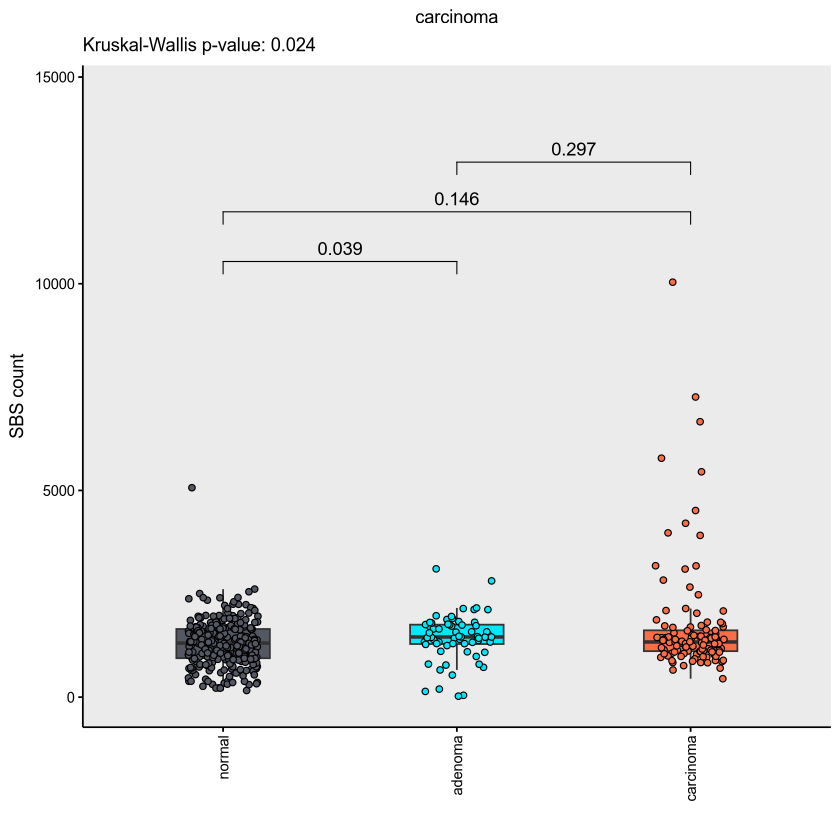

In [29]:
F2a_sbs_boxplot

Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


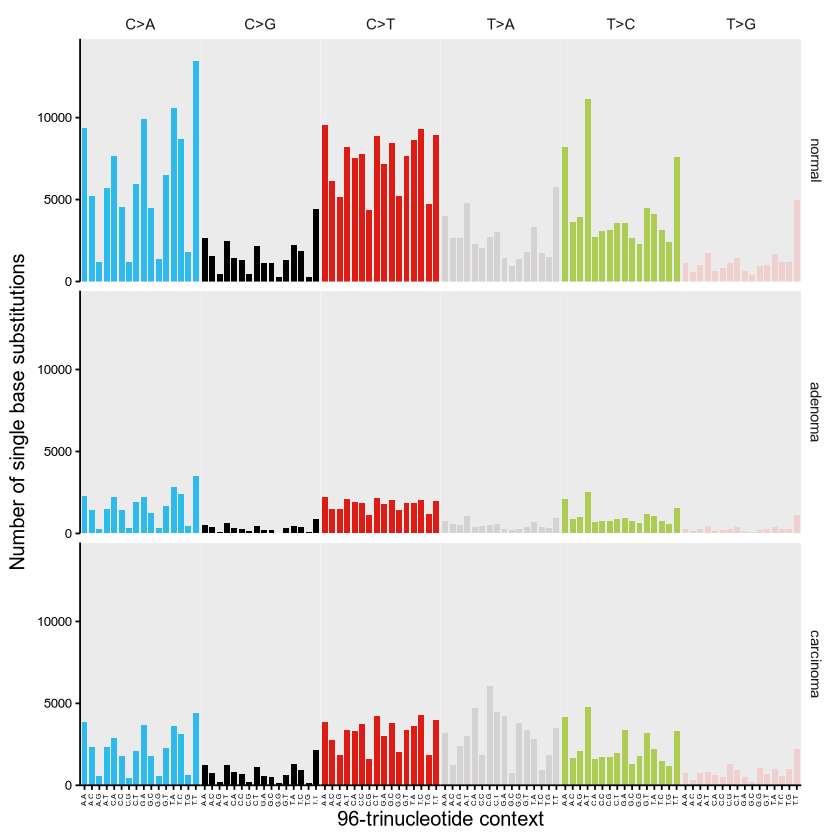

In [30]:
F2c_sbs_profile

In [42]:
indel_mut_counts = mut_counts %>%
    mutate('indel count' = colSums(indel_counts[, name]))

indel_mut_counts = indel_mut_counts %>% arrange(method, injection)
  sjPlot::tab_df(indel_mut_counts, file = "Output/Supplementary_tables/Supplementary_Table_1.doc")

  #  Plot indel counts and mutational profiles
  indel_mut_counts_plot = indel_mut_counts

  ktest_indels = kruskal.test(`indel count` ~ injection, indel_mut_counts_plot)
  subtitle = paste0("Kruskal-Wallis p-value: ", round(ktest_indels$p.value, 3))

In [43]:
mm = t(mut_mat) %>% data.table(keep.rownames = "name")
  mm = merge(mm, mut_counts[,-4])
  mm_cat = mm %>% group_by(injection, method) %>%
    dplyr::select(-name) %>%
    summarize_all(sum) %>%
    dplyr::select(-method) %>%
    column_to_rownames("injection") %>%
    t()

  F2c_sbs_profile = plot_96_profile3(mm_cat) +
    theme(axis.text.x = element_text(size = 4.5))

Warning message in geom_bar(stat = "identity", size = 0.3):
“Ignoring unknown parameters: `size`”
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


In [44]:
F2b_boxplot_indels = ggplot(indel_mut_counts_plot, aes(x = injection, y = `indel count`, fill = injection)) +
    geom_boxplot(outlier.shape = NA, width = 0.4) +
    geom_jitter(shape = 21, width = 0.15) +
    geom_pwc(aes(group = injection), method = "dunn_test",
             dodge = 0.2, p.adjust.by = "panel", label = "{p.adj.format}", p.adjust.method = "fdr") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    scale_y_continuous(limits = c(0, max(indel_mut_counts$`indel count`)*1.45)) +
    theme_BM() +
    theme(plot.title = element_text(hjust = 0.5, size = 11),
          legend.position = "none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    labs(title = "Indels", subtitle = subtitle, x = "")

  # Plot indel profiles
  indel_counts = indel_counts[, cat$name]
  id_mm = t(indel_counts) %>% data.table(keep.rownames = "name")
  id_mm = merge(id_mm, indel_mut_counts[,-4])
  id_mm = id_mm %>% group_by(injection, method) %>%
    dplyr::select(-name, -`indel count`) %>%
    summarize_all(sum) %>%
    dplyr::select(-method) %>%
    column_to_rownames("injection") %>%
    t()

Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


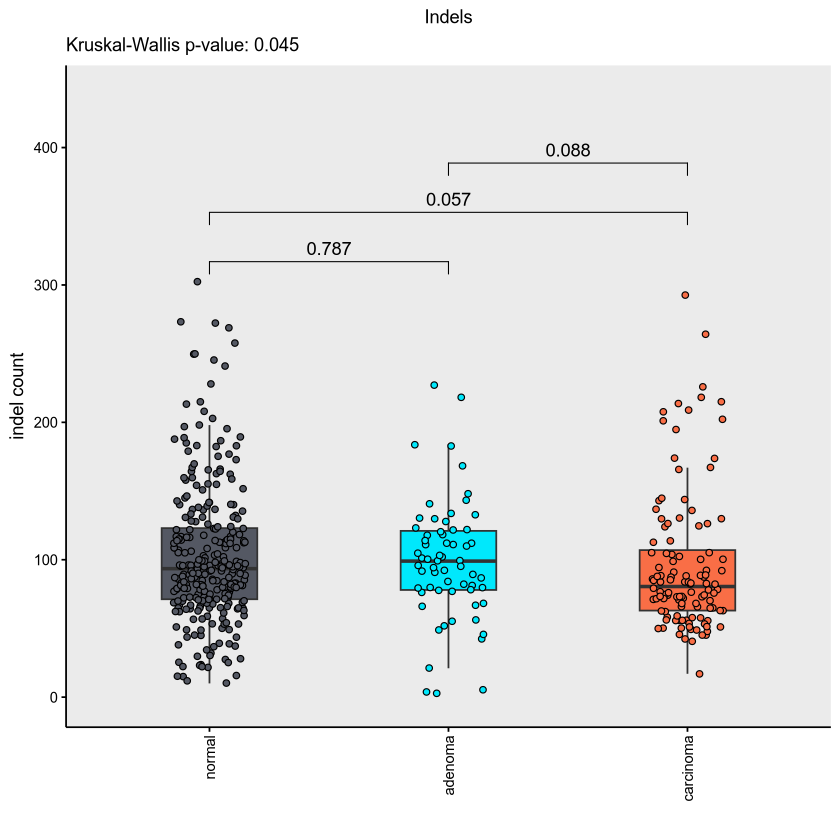

In [45]:
F2b_boxplot_indels

In [46]:
F2d_indel_profile = plot_indel_contexts2(id_mm) +
    theme_minimal_hgrid() +
    scale_y_continuous(n.breaks = 3) +
    theme(panel.spacing.x = unit(0, "mm"),
          legend.position = "none",
          axis.text.x = element_text(size = 5),
          strip.text.y = element_text(size = 9),
          axis.text.y = element_text(size = 8))

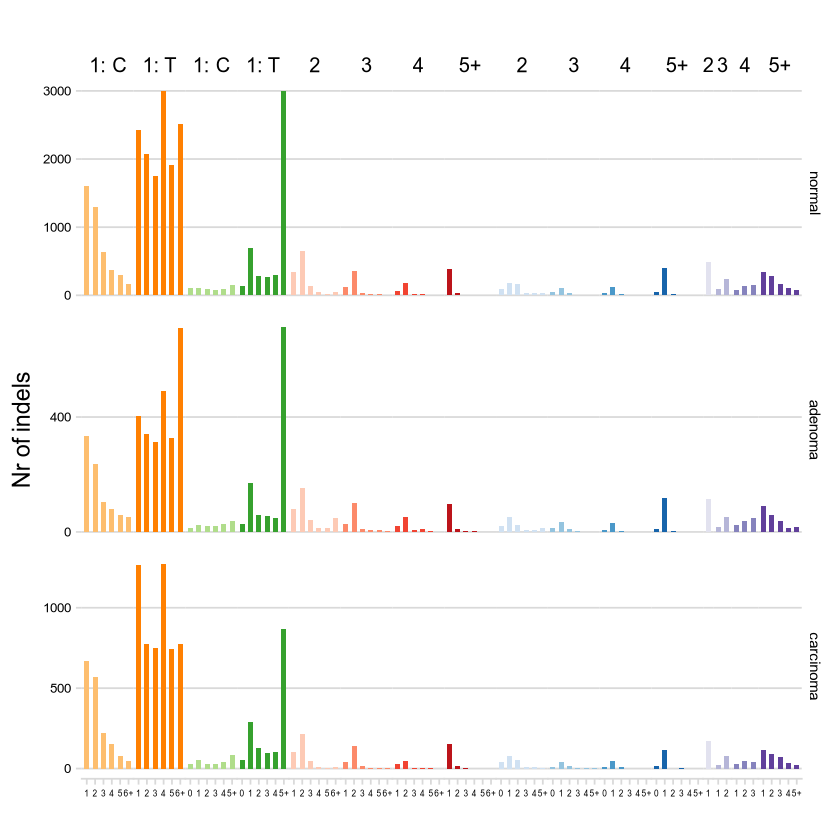

In [47]:
F2d_indel_profile

In [48]:
cos_sim(id_mm[,"normal"], id_mm[, "adenoma"])
cos_sim(id_mm[,"normal"], id_mm[, "carcinoma"])
cos_sim(id_mm[,"adenoma"], id_mm[, "carcinoma"])

[1] 0.9773328

[1] 0.9817414

[1] 0.9298406

In [48]:
signatures = read_delim("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/COSMIC_v3.5_SBS_GRCh38.txt") %>%
  arrange(match(Type, TRIPLETS_96))
artefact_signatures = c("SBS27", "SBS43","SBS45","SBS46", "SBS47","SBS48","SBS49","SBS50","SBS51","SBS52",'SBS53',"SBS54",'SBS55','SBS56','SBS57','SBS58','SBS59','SBS60')
sigs = signatures[,!colnames(signatures) %in% artefact_signatures] # remove signatures marked as artefacts
id_signatures = read_delim("/uufs/chpc.utah.edu/common/HIPAA/u1264408/u1264408/Git/SEMIColon/data/COSMIC_v3.4_ID_GRCh37.txt")

Rows: 96 Columns: 98
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Type
dbl (97): SBS1, SBS2, SBS3, SBS4, SBS5, SBS6, SBS7a, SBS7b, SBS7c, SBS7d, SB...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 83 Columns: 24
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (1): Type
dbl (23): ID1, ID2, ID3, ID4, ID5, ID6, ID7, ID8, ID9, ID10, ID11, ID12, ID1...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [34]:
sigs_known = signatures[, c("SBS1", "SBS5", "SBS18", "SBS88")]

In [35]:
fit_res = fit_to_signatures(mut_mat, as.matrix(sigs_known))

In [36]:
fit_res_clones_sbs = fit_res$contribution %>%
    prop.table(2) %>%
    as.data.frame() %>% rownames_to_column("Signature") %>%
    pivot_longer(cols = -Signature) %>%
    filter(Signature == "SBS88")
  fit_res_clones_sbs = merge(fit_res_clones_sbs, categories)

In [ ]:
#fit_res_clones_sbs

name,Signature,value,injection,method
<chr>,<chr>,<dbl>,<fct>,<chr>
029_DC_T,SBS88,0.0000000000,adenoma,Crypt
030_CE_T,SBS88,0.0000000000,adenoma,Crypt
031_RE_T,SBS88,0.0333306272,adenoma,Crypt
058_RE_T,SBS88,0.0018754333,normal,Crypt
103_RE,SBS88,0.0526898429,normal,Crypt
116_RE_T,SBS88,0.1284710345,adenoma,Crypt
116_TR,SBS88,0.0000000000,adenoma,Crypt
12b_D12_84_TR,SBS88,0.0000000000,adenoma,Crypt
148_SI,SBS88,0.1339573610,normal,Crypt


In [ ]:
#write.csv(fit_res_clones_sbs, file = paste0("2026_01_26_SBS88_refit.csv"), row.names = FALSE)

Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”
Warning message:
“Removed 152 rows containing missing values or values outside the scale range
(`geom_point()`).”


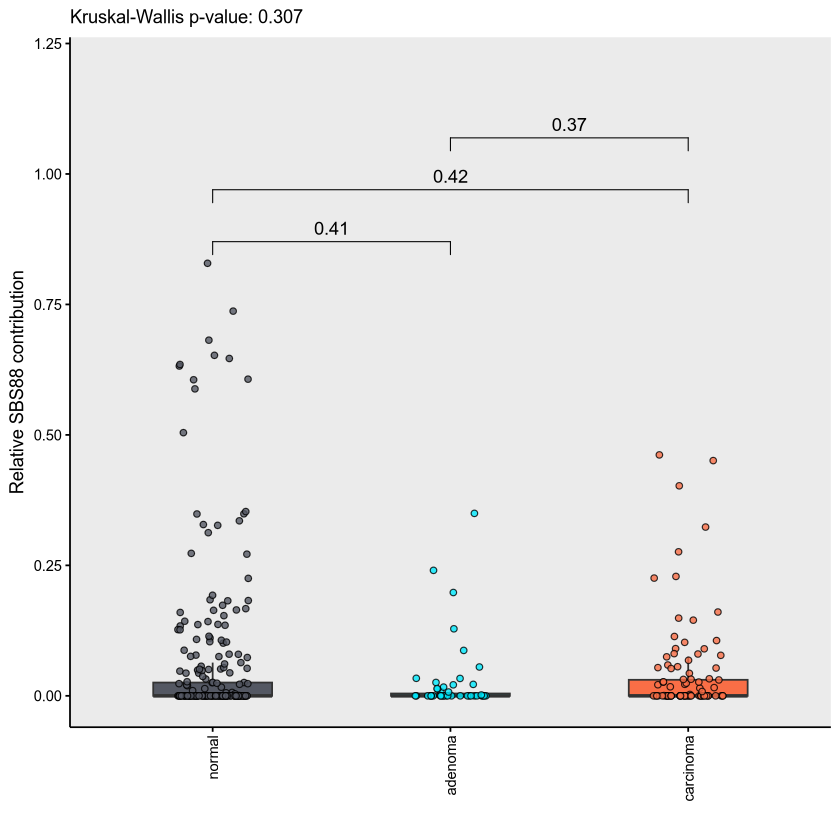

In [37]:
ktest_refit = kruskal.test(value ~ injection, data = fit_res_clones_sbs)
  subtitle = paste0("Kruskal-Wallis p-value: ", round(ktest_refit$p.value, 3))


  F2g_sbs_refit = ggplot(fit_res_clones_sbs, aes(x = injection, y = value, fill = injection,shape = method))  +
    geom_boxplot(aes(shape = NULL), outlier.shape = NA, width = 0.5) +
    geom_jitter(shape = 21, width = 0.15, alpha = 0.8)  +
    theme_BM() +
    geom_pwc(aes(group = injection), method = "dunn_test", p.adjust.method =  "fdr", label = "{p.adj.format}") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    scale_y_continuous(limits = c(0, max(fit_res_clones_sbs$value)*1.45)) +
    labs( y = "Relative SBS88 contribution", x ="", subtitle = subtitle) +
    theme(legend.position =  "none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
  F2g_sbs_refit

In [57]:
id_sigs_select = id_signatures[, c("ID1", "ID2", "ID18")]
  fit_res_id = fit_to_signatures(indel_counts, as.matrix(id_sigs_select))
  fit_res_clones = fit_res_id$contribution %>%
    prop.table(2) %>%
    as.data.frame() %>% rownames_to_column("Signature") %>%
    pivot_longer(cols = -Signature) %>%
    filter(Signature == "ID18")
  fit_res_clones = merge(fit_res_clones, categories)

In [58]:
ktest_refit = kruskal.test(value ~ injection, data = fit_res_clones)
subtitle = paste0("Kruskal-Wallis p-value: ", round(ktest_refit$p.value, 3))

In [59]:
Fig2h_indel_refit = ggplot(fit_res_clones, aes(x = injection, y = value, fill = injection,shape = method))  +
    geom_boxplot(aes(shape = NULL), outlier.size = 0, width = 0.5) +
    geom_jitter(shape = 21, width = 0.15, alpha = 0.8)  +
    theme_BM() +
    geom_pwc(aes(group = injection), method = "dunn_test", p.adjust.method =  "fdr", label = "p.adj.format") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    scale_y_continuous(limits = c(0, max(fit_res_clones$value)*1.30)) +
    labs(subtitle = subtitle, y = "Relative ID18 contribution", x = "") +
    theme(legend.position =  "none", axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

In [ ]:
#write.csv(fit_res_clones, file = paste0("2026_01_26_ID18_refit.csv"), row.names = FALSE)

name,Signature,value,injection,method
<chr>,<chr>,<dbl>,<fct>,<chr>
029_DC_T,ID18,0.4363282,adenoma,Crypt
030_CE_T,ID18,0.3762533,adenoma,Crypt
031_RE_T,ID18,0.8426743,adenoma,Crypt
058_RE_T,ID18,0.5315820,normal,Crypt
103_RE,ID18,0.6480194,normal,Crypt
116_RE_T,ID18,0.7920970,adenoma,Crypt
116_TR,ID18,0.5951441,adenoma,Crypt
12b_D12_84_TR,ID18,0.5286693,adenoma,Crypt
148_SI,ID18,0.6808038,normal,Crypt


Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


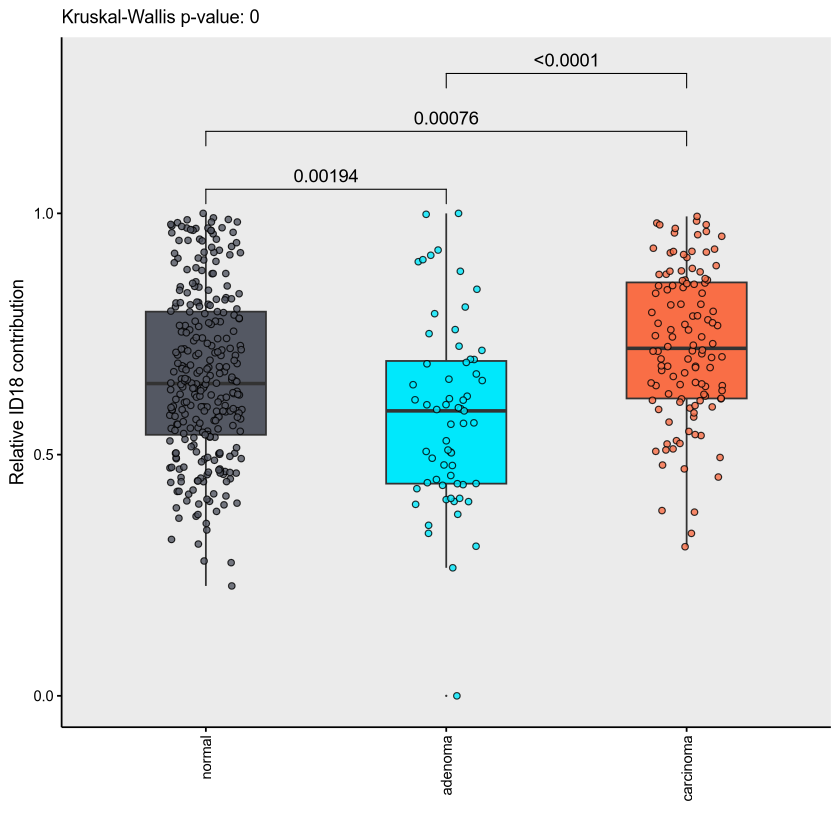

In [52]:
Fig2h_indel_refit

In [68]:
# Rebuttal figure 2: Mutational loads for signatures in absolute counts
fit_res_clones = fit_res_id$contribution %>%
    as.data.frame() %>% rownames_to_column("Signature") %>%
    pivot_longer(cols = -Signature) %>%
    filter(Signature == "ID18")

fit_res_clones = merge(fit_res_clones, categories)

rebuttal_2_indel_refit = ggplot(fit_res_clones, aes(x = injection, y = value, fill = injection,shape = method))  +
    geom_boxplot(aes(shape = NULL), outlier.size = 0, width = 0.15, alpha = 0.6) +
    geom_jitter(width = 0.15, alpha = 0.8)  +
    theme_BM() +
    geom_pwc(aes(group = injection), ref.group	= "Control", p.adjust.method =  "fdr", label = "p.adj") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    ylab("Absolute ID18 contribution") + xlab("") +
    theme(legend.position =  "none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggtitle("Indels")

fit_res_clones_sbs = fit_res$contribution %>%
    as.data.frame() %>% rownames_to_column("Signature") %>%
    pivot_longer(cols = -Signature) %>%
    filter(Signature == "SBS88")

fit_res_clones_sbs = merge(fit_res_clones_sbs, categories)


Warning message:
“Computation failed in `stat_pwc()`.
Caused by error in `if (ref.group != "") ...`:
! missing value where TRUE/FALSE needed”
Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


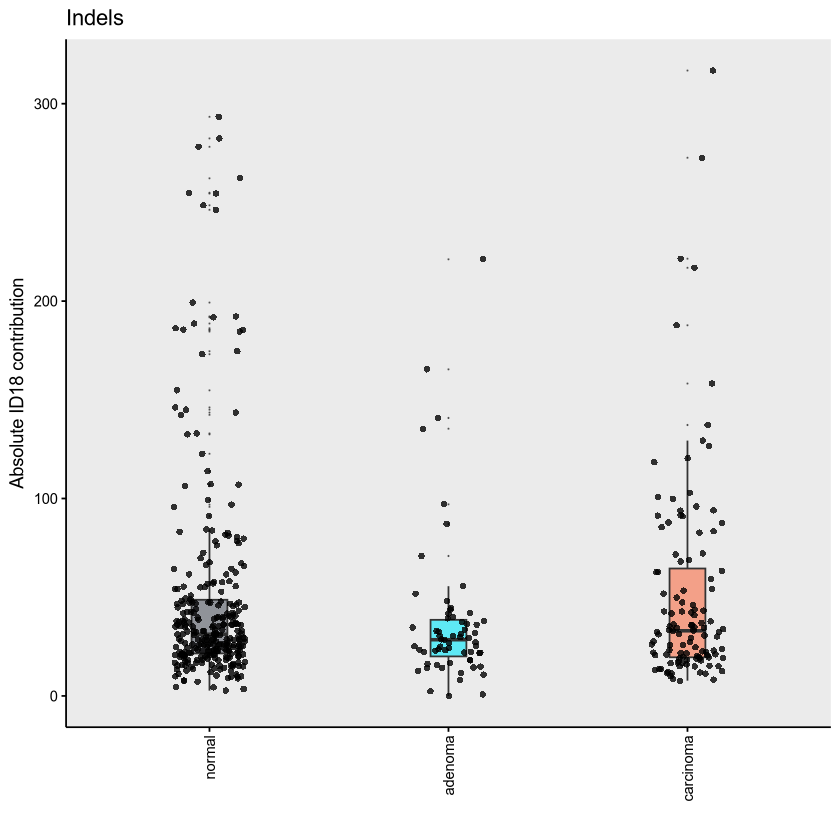

In [66]:
rebuttal_2_indel_refit

In [ ]:
#fit_res_clones
#write.csv(fit_res_clones, file = paste0("2026_01_26_ID18_refit_abs.csv"), row.names = FALSE)


name,Signature,value,injection,method
<chr>,<chr>,<dbl>,<fct>,<chr>
029_DC_T,ID18,23.390808,adenoma,Crypt
030_CE_T,ID18,39.301712,adenoma,Crypt
031_RE_T,ID18,87.105802,adenoma,Crypt
058_RE_T,ID18,24.718574,normal,Crypt
103_RE,ID18,65.908500,normal,Crypt
116_RE_T,ID18,140.811607,adenoma,Crypt
116_TR,ID18,41.964629,adenoma,Crypt
12b_D12_84_TR,ID18,21.828486,adenoma,Crypt
148_SI,ID18,76.298367,normal,Crypt


In [62]:
rebuttal_2_sbs_refit = ggplot(fit_res_clones_sbs, aes(x = injection, y = value, fill = injection,shape = method))  +
    geom_boxplot(aes(shape = NULL), outlier.shape = NA, width = 0.15, alpha = 0.6) +
    geom_jitter(width = 0.15, alpha = 0.8)  +
    theme_BM() +
    geom_pwc(aes(group = injection), ref.group	= "Control", p.adjust.method =  "fdr", label = "p.adj") +
    scale_fill_manual(values = c("#545863", "#00e8fc", "#f96e46", "#f9c846", "#ffe3e3")) +
    ylab("Absolute SBS88 contribution") + xlab("") +
    theme(legend.position =  "none",
          axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) +
    ggtitle("singe base substitutions")

Warning message:
“Computation failed in `stat_pwc()`.
Caused by error in `if (ref.group != "") ...`:
! missing value where TRUE/FALSE needed”
Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


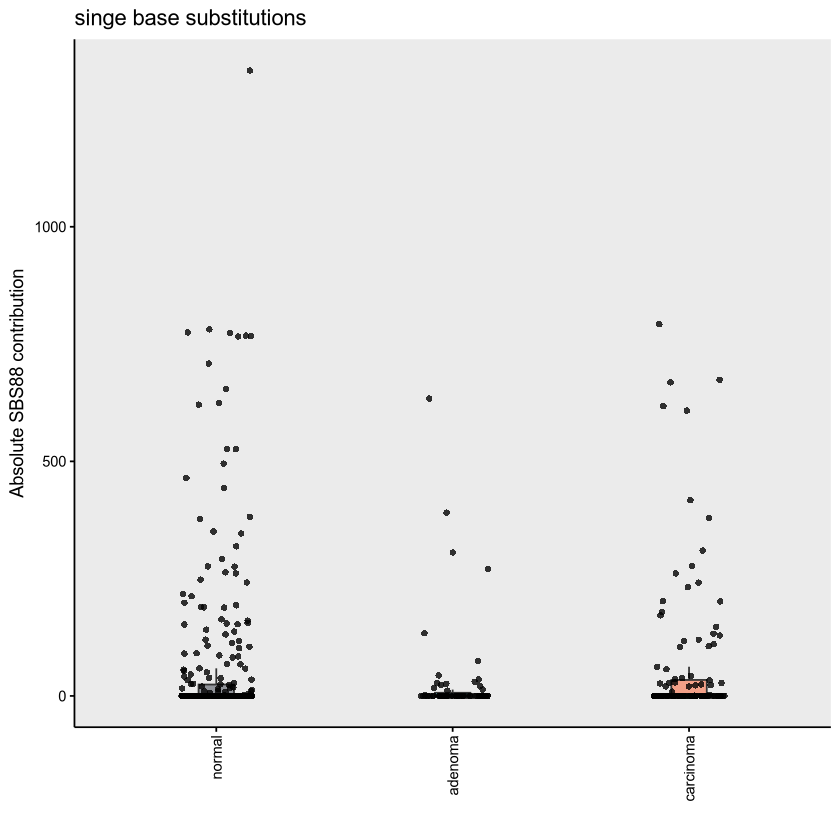

In [63]:
rebuttal_2_sbs_refit

In [ ]:
#fit_res_clones_sbs
#write.csv(fit_res_clones_sbs, file = paste0("2026_01_26_SBS88_refit_abs.csv"), row.names = FALSE)

name,Signature,value,injection,method
<chr>,<chr>,<dbl>,<fct>,<chr>
029_DC_T,SBS88,0.0000000,adenoma,Crypt
030_CE_T,SBS88,0.0000000,adenoma,Crypt
031_RE_T,SBS88,43.7164070,adenoma,Crypt
058_RE_T,SBS88,1.9284718,normal,Crypt
103_RE,SBS88,86.4116953,normal,Crypt
116_RE_T,SBS88,270.5124143,adenoma,Crypt
116_TR,SBS88,0.0000000,adenoma,Crypt
12b_D12_84_TR,SBS88,0.0000000,adenoma,Crypt
148_SI,SBS88,154.4601593,normal,Crypt


In [62]:
mm = t(mut_mat) %>% data.table(keep.rownames = "name")
mm = merge(categories, mm, by = "name")

In [63]:
mm_cat = mm %>% group_by(injection, method) %>%
  dplyr::select(-name) %>%
  summarize_all(sum) %>%
  mutate(name = paste0(method, "-", injection)) %>%
  mutate(name = gsub("Clonal Expansion-", "CE", name)) %>%
  ungroup() %>%
  dplyr::select(-method, -injection) %>%
  column_to_rownames("name") %>%
  as.matrix() %>%
  t()

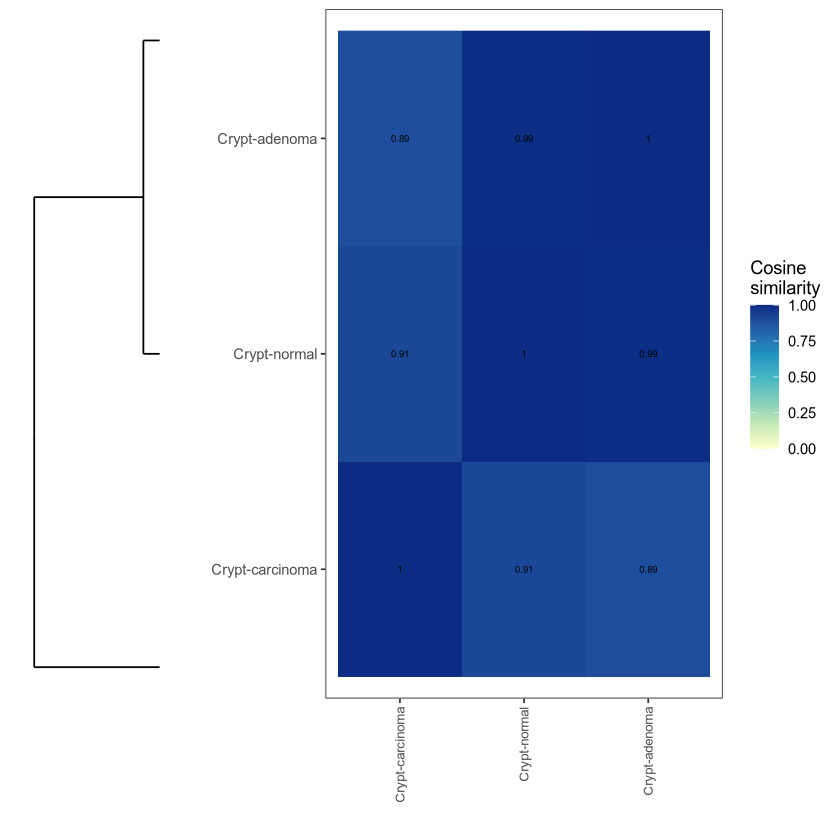

In [64]:
cossim_all = cos_sim_matrix(mm_cat, mm_cat)
cos_mat_sbs = plot_cosine_heatmap2(cossim_all, cluster_cols = TRUE, plot_values = TRUE)
cos_mat_sbs


In [65]:
# Indel cosine similarities:
id_mm = t(indel_counts) %>% data.table(keep.rownames = "name")
id_mm = merge(id_mm, categories) %>% group_by(injection, method) %>%
  dplyr::select(-name) %>%
  summarize_all(sum) %>%
  mutate(name = paste0(method, "-", injection)) %>%
  mutate(name = gsub("Clonal Expansion-", "CE", name)) %>%
  ungroup() %>%
  dplyr::select(-method, -injection) %>%
  column_to_rownames("name") %>%
  as.matrix() %>%
  t()

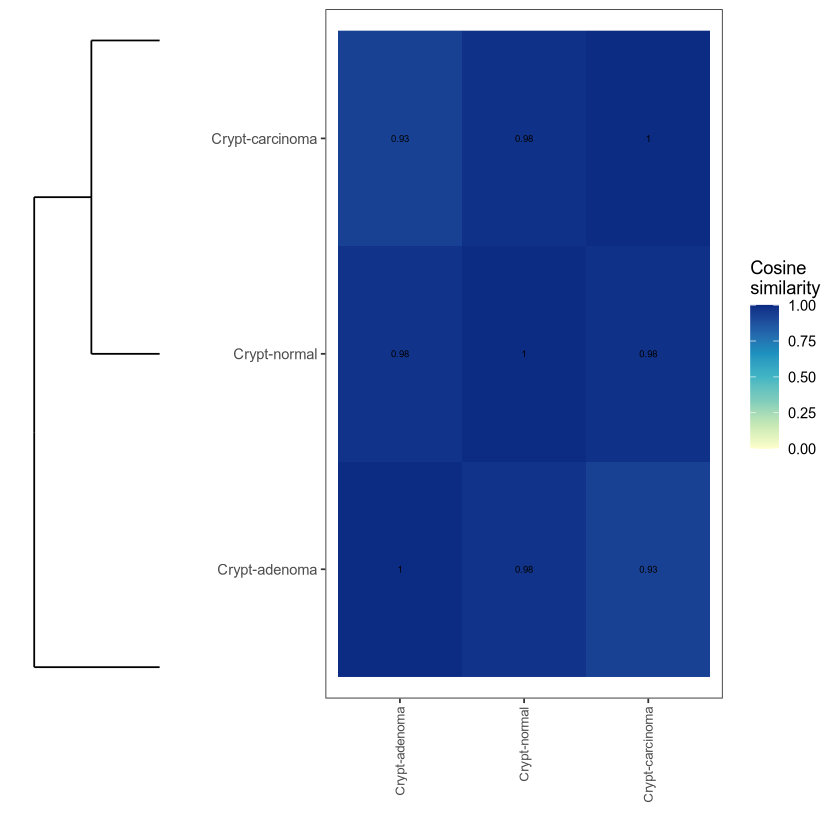

In [66]:
cosine_indel_all = cos_sim_matrix(id_mm, id_mm)
cos_mat_indel = plot_cosine_heatmap2(cosine_indel_all, cluster_cols = TRUE, plot_values = TRUE) +
  guides(fill = "")
cos_mat_indel


Below here is the Figure 2 stuff

In [67]:
# function to make the script a bit shorter:

get_profile_labels = function(ext_context, TN_signature) {

  context_counts = ext_context %>%
    group_by(name, select, trinucleotide) %>%
    dplyr::count() %>%
    pivot_wider(values_from = n, names_from = trinucleotide, values_fill = 0) %>%
    ungroup() %>% as.data.table()

  # get the trinucleotide profile for the total samples:
  type_counts_all = context_counts[, lapply(.SD, sum), by = c("name"),
                                   .SDcols = names(context_counts) %like% "[.>.]"]
  type_counts_all = type_counts_all %>%
    column_to_rownames("name") %>%
    t() %>% as.data.frame()
  type_counts_all = type_counts_all[TRIPLETS_48,]
  cosines_TN = sapply(type_counts_all, cos_sim, TN_signature)
  spearman_TN = sapply(type_counts_all, cor, TN_signature, method = "spearman") # get cosine similarities to SBS T>N fraction
  spearman_TN_pval = sapply(type_counts_all, \(x) cor.test(x, TN_signature, method = "spearman")$p.value) %>%
    p.adjust(method = 'fdr') %>%
    formatC(format = "e", digits = 2)# get spearman correlation


  TN_trinuc_counts = context_counts %>% filter(select == "AA") %>%
    dplyr::select(-select) %>% column_to_rownames("name") %>%
    t() %>% as.data.frame()
  TN_trinuc_counts = TN_trinuc_counts[TRIPLETS_48,]

  cosines_TN_AA = sapply(TN_trinuc_counts, cos_sim, TN_signature)
  spearman_TN_AA = sapply(TN_trinuc_counts, cor, TN_signature, method = "spearman")
  spearman_TN_AA_pval = sapply(TN_trinuc_counts, \(x) cor.test(x, TN_signature, method = "spearman")$p.value) %>%
    p.adjust(method = 'fdr') %>%
    formatC(format = "e", digits = 2)# get cosine similarities to SBS T>N fraction


  label_df = data.frame(name = factor(names(cosines_TN), levels = names(cosines_TN)),
                        cosine_TN = cosines_TN,
                        spearman_TN = spearman_TN,
                        cosine_TN_AA = cosines_TN_AA,
                        spearman_TN_AA = spearman_TN_AA,
                        label_cosine = paste0("all T>N: ", round(cosines_TN, 2),
                                              "\nT>N -3-4AA: ", round(cosines_TN_AA, 2)),
                        label_spearman = paste0(round(spearman_TN, 2) ,
                                       "\n", round(spearman_TN_AA, 2)),
                        label_pval = paste0(spearman_TN_pval, "\n", spearman_TN_AA_pval))

  return(label_df)
}


In [74]:
contexts_TN = list()
for (type in names(context_list)) {
  ctx_table= context_list[[type]] %>%
    rbindlist() %>%
    distinct() %>%
    filter(grepl("^T", type))
  contexts_TN[[type]] = ctx_table
}

In [75]:
cat_CE = categories %>%
  filter(method == "Crypt")
cat_CE$injection = factor(cat_CE$injection, levels = c("normal", "adenoma", "carcinoma"))

In [76]:
contexts_TN_CE = list()
for (type in unique(cat_CE$injection)) {
  ctx_table= context_list[[type]] %>%
    rbindlist(idcol = "samplename") %>%
    filter(samplename %in% cat_CE$name) %>%
    dplyr::select(-samplename) %>%
    distinct() %>%
    filter(grepl("^T", type))
  contexts_TN_CE[[type]] = ctx_table
}

In [77]:
ext_context = rbindlist(contexts_TN_CE,, idcol = "name") %>%
    mutate(pos34 =  substr(context, 7,8)) %>%
    mutate(trinucleotide = factor(trinucleotide, levels = TRIPLETS_48)) %>%
    mutate(select =  ifelse(pos34 == "AA", "AA", "other") %>%
             factor(levels = c("other", "AA"))) %>%
    mutate(name = name %>% factor(levels = levels(cat$injection)))

In [78]:
ext_context

name,chr,position,type,strand,context,trinucleotide,id,pos34,select
<fct>,<chr>,<int>,<chr>,<chr>,<chr>,<fct>,<chr>,<chr>,<fct>
adenoma,chr1,3714100,T>G,+,GGGTCAGAGATTCGGAGGCCA,A[T>G]T,chr1_3714100_T>G,GA,other
adenoma,chr1,9183815,T>G,-,CCAAATGTGATTACGCACCTG,A[T>G]T,chr1_9183815_T>G,GT,other
adenoma,chr1,14386619,T>C,+,AATTCTTTTCTTTAAGAATGT,C[T>C]T,chr1_14386619_T>C,TT,other
adenoma,chr1,22397072,T>C,-,CAATTTCCAGTTTATACCAAG,G[T>C]T,chr1_22397072_T>C,CC,other
adenoma,chr1,23174767,T>A,+,GATTACCCAGTATGATTGAGG,G[T>A]A,chr1_23174767_T>A,CC,other
adenoma,chr1,27770385,T>C,-,ATCCTCCAGGTAAGAGTGATA,G[T>C]A,chr1_27770385_T>C,CA,other
adenoma,chr1,32080093,T>C,+,TTTCACCGTGTTAGCCAGGAT,G[T>C]T,chr1_32080093_T>C,CG,other
adenoma,chr1,44932233,T>C,+,CTAGCATCATTTGTACACATA,T[T>C]T,chr1_44932233_T>C,TC,other
adenoma,chr1,50864677,T>C,-,TTGATTTTTGTATAAGGTGTA,G[T>C]A,chr1_50864677_T>C,TT,other


In [72]:
label_df = get_profile_labels(ext_context, SBS88_TN)
  # Add the explaining label on the plot:
  label_df$label_cosine = paste0("SBS88:    cosine similarity\n", label_df$label_cosine)
  label_df$label_spearman = paste0("spearman\n", label_df$label_spearman)
  label_df$label_pval = paste0("pval\n", label_df$label_pval)

Warning message in cor.test.default(x, TN_signature, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, TN_signature, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, TN_signature, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, TN_signature, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, TN_signature, method = "spearman"):
“Cannot compute exact p-value with ties”
Warning message in cor.test.default(x, TN_signature, method = "spearman"):
“Cannot compute exact p-value with ties”


In [73]:
F3e_AA_context_profile <- ext_context %>%
      mutate(select =  fct_recode(select, "-3-4AA" = "AA")) %>%
      group_by(trinucleotide, select) %>%
      ggplot(aes(x = trinucleotide, alpha = select, fill = type)) +
      geom_bar(width = 0.7 ) +
      facet_grid(name ~ . , scales  = "free_y") +
      theme_BM()  +
      scale_alpha_manual(values = c(0.3, 1)) +
      scale_fill_manual(values = COLORS6[4:6]) +
      theme(legend.position = "top",
            legend.box = "horizontal",
            axis.text.x = element_text(size= 6.5, angle = 90, vjust = 0.5, hjust=1),
            legend.box.background = element_rect(colour = "black", fill = NA),
            legend.background =element_blank(),
            legend.text = element_text(size=7),
            legend.title = element_blank(),
            strip.background = element_blank(),
            strip.text.y = element_blank(),
            legend.key.size = unit(7, "points"),
            plot.margin = margin(unit(c(3, 8, 8, 8), "points"))) +
      xlab("") + ylab("Mutation count") +
    labs(alpha = "nucs at pos -3-4", fill = NULL) +
    ggpp::geom_text_npc(data = label_df, npcx = 0.98, npcy = 0.9,
                        aes(label = label_pval), size = 2.5, hjust = 1) +
    ggpp::geom_text_npc(data = label_df, npcx = 0.88, npcy = 0.9,
                        aes(label = label_spearman), size = 2.5, hjust = 1) +
    ggpp::geom_text_npc(data = label_df, npcx = 0.78, npcy = 0.9,
                       aes(label = label_cosine), size = 2.5, hjust = 1) +
      ggpp::geom_text_npc(data = label_df, npcx = 0.02, npcy = 0.9,
                        aes(label = name), size = 3.5, hjust = 0)

Warning message:
“In `margin()`, the argument `t` should have length 1, not length 4.
ℹ Argument get(s) truncated to length 1.”


Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


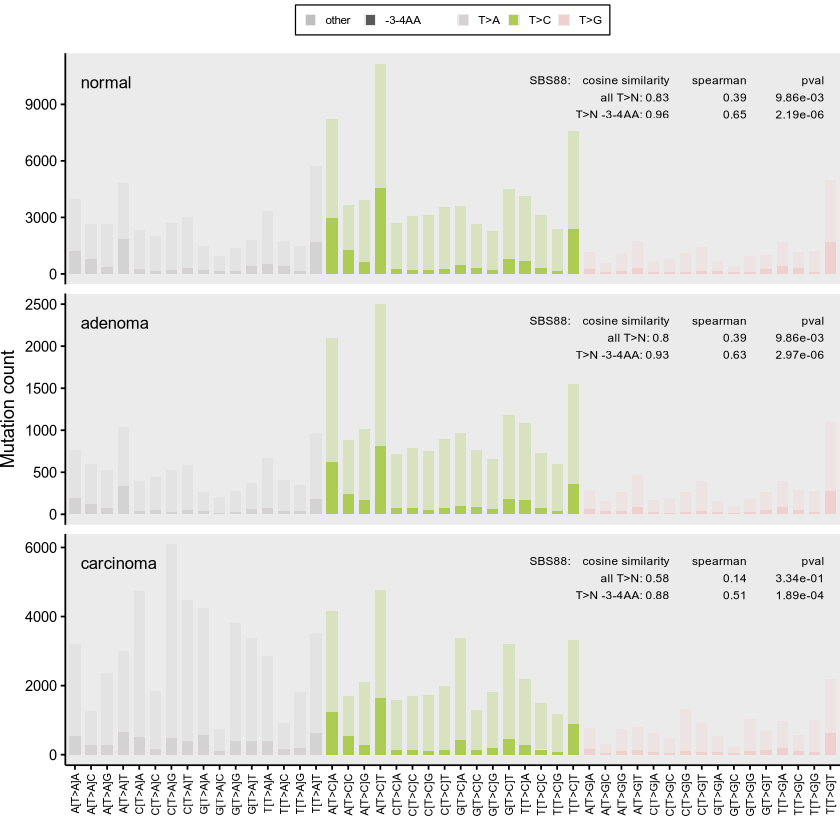

In [74]:
F3e_AA_context_profile

In [75]:
list = split(ext_context, ext_context$name)
  occurrence_mat = sapply(list, function(x) table(x$select))
  AA_occurrence_mat_percentages = occurrence_mat[2,] / colSums(occurrence_mat)

  # get the enrichment scores for only A mutations at the -3 site:
  list3 = list %>% rbindlist() %>%
    mutate(pos3 = substr(pos34, 2,2))

  occurrence_mat_A = table(list3$name, list3$pos3) %>% as.data.frame.matrix()
  A_occurrence_mat_percentages = occurrence_mat_A[,1] / rowSums(occurrence_mat_A)
  AA_occurrence_mat_percentages /A_occurrence_mat_percentages

  # perform fisher test on all motif enrichments
  dinuc_counts = sapply(list, function(x) table(x$pos34))

normal   adenoma carcinoma 
0.5097629 0.4678292 0.4212237

Warning message:
“In `margin()`, the argument `t` should have length 1, not length 4.
ℹ Argument get(s) truncated to length 1.”


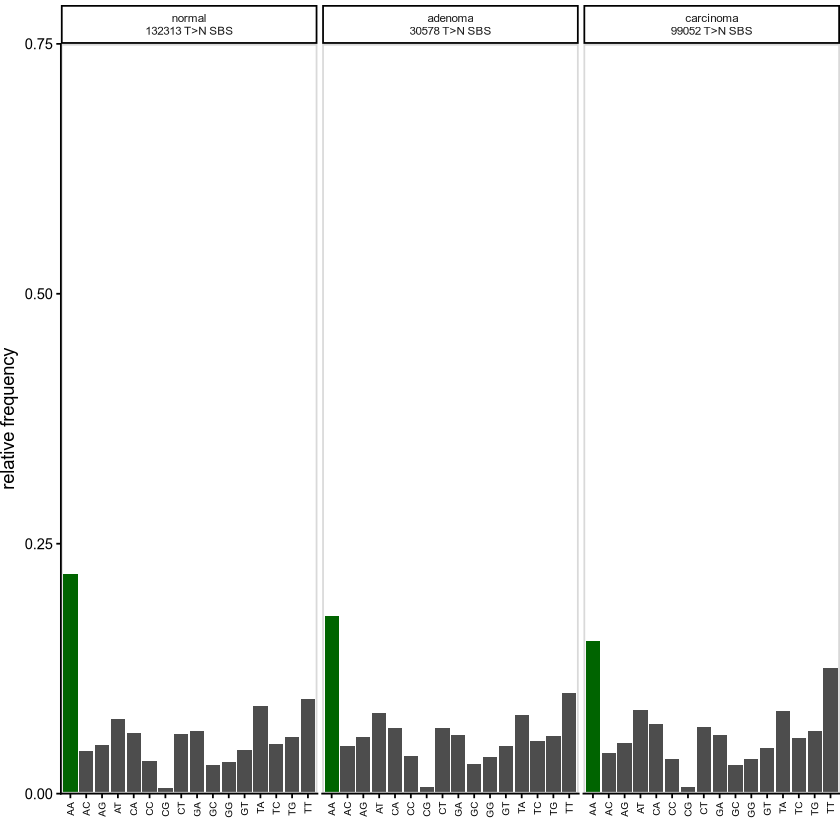

In [76]:
colnames(dinuc_counts) = paste0(colnames(dinuc_counts), "\n", colSums(dinuc_counts)," T>N SBS")
  dinuc_long = prop.table(dinuc_counts, 2) %>%
    data.table(keep.rownames = "Dinucleotide") %>%
    mutate(color = ifelse(Dinucleotide == "AA", "AA", "noAA")) %>%
    pivot_longer(cols = c(-Dinucleotide, -color), names_to = "Condition", values_to = "relative frequency") %>%
    mutate(Condition = factor(Condition, levels = colnames(dinuc_counts)))

  F3c_dinuc_frequencies = ggplot(dinuc_long) +
    geom_bar(aes(x = Dinucleotide, y = `relative frequency`, fill = color), stat = "identity") +
    facet_grid(. ~ Condition , scales = "free_y") +
    theme_classic() +  panel_border()  +
    scale_y_continuous(expand = c(0, 0), limits = c(0,0.75), breaks = seq(0, 0.75, 0.25)) +
    scale_fill_manual(values = c("darkgreen", "gray30")) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1,  size = 6 ),
          strip.text.x = element_text(size = 7),
          legend.position = "none", panel.spacing.x = unit(1, units = "mm"),
          plot.margin = margin(unit(c(3, 3, 3, 3), "points")))  +
    ylab("relative frequency") + xlab("")
F3c_dinuc_frequencies

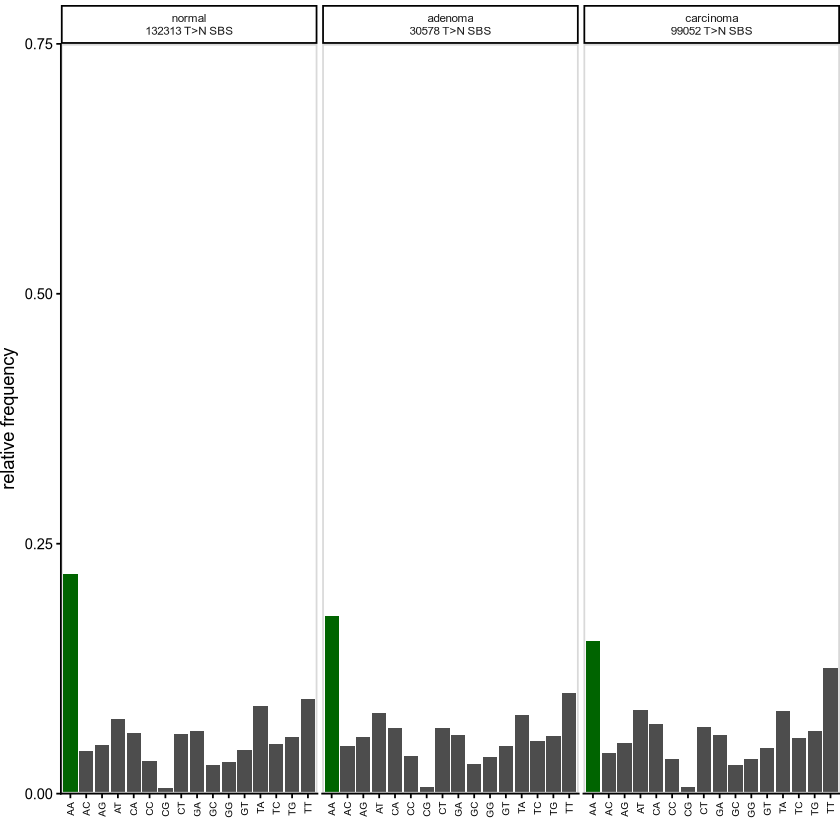

In [77]:
F3c_dinuc_frequencies

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.
ℹ The deprecated feature was likely used in the ggseqlogo package.
  Please report the issue at <https://github.com/omarwagih/ggseqlogo/issues>.”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message in plot_theme(plot):
“The `panel.backgroun` theme element is not defined in the element hierarchy.”


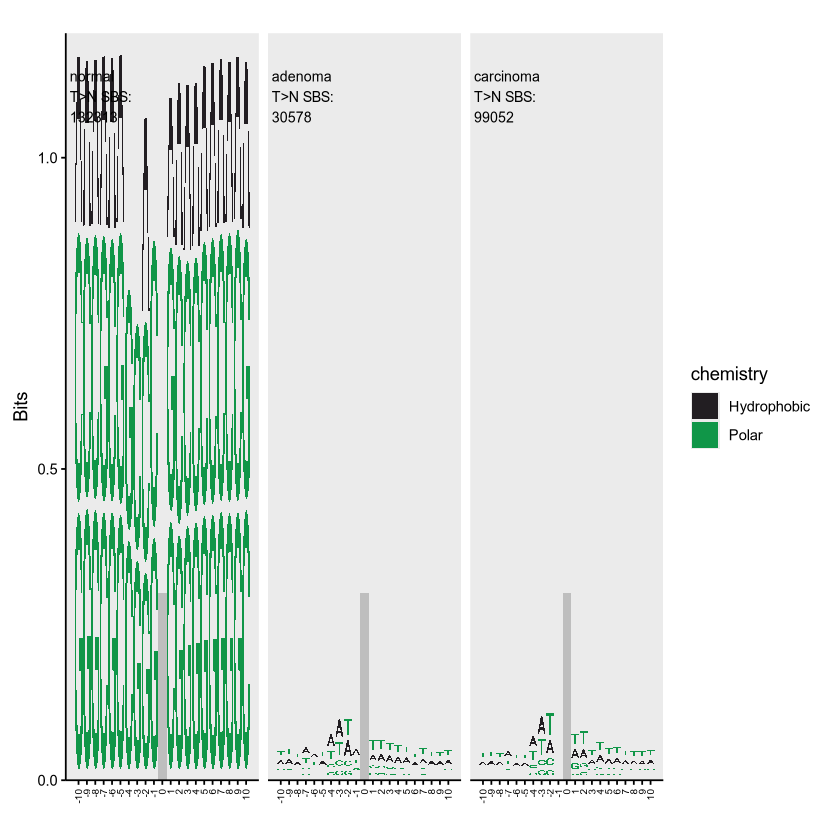

In [79]:
TNctx = list()
  for (type in levels(cat$injection)) {
    type_context = contexts_TN[[type]]$context
    TNctx[[type]] = type_context
  }

  TNctx = TNctx[c("normal", "adenoma", "carcinoma")]
  TNctx = TNctx[1:length(levels(cat$injection))]

  labels = data.frame(seq_group = factor(names(TNctx), names(TNctx)),
                      label = paste0(names(TNctx), "\nT>N SBS:\n", lengths(TNctx)))

  F3a_seqlogo_plots = ggseqlogo(TNctx) +
    annotate('rect', xmin = 10.5, xmax = 11.5, ymin = 0, ymax = 0.3, fill='grey') +
    scale_x_continuous(breaks = c(1:21), labels= c(-10:10)) +
    scale_y_continuous(limits = c(0,1.2), expand = c(0,0), breaks = c(0, 0.5, 1)) +
    ggpp::geom_text_npc(data = labels, aes(label = label),
                        npcx = 0.02, npcy = 0.95, hjust = 0, size = 3) +
    xlab("") +
    theme_BM() +
    theme( strip.background = element_blank(),
                        strip.text.x = element_blank(),
           axis.text.x = element_text(size = 6, angle = 90, vjust = 0.5, hjust=1),
           plot.margin = margin(20, 8, 8, 8, unit = "pt"))
  F3a_seqlogo_plots


In [80]:
dinuc_counts

,normal 132313 T>N SBS,adenoma 30578 T>N SBS,carcinoma 99052 T>N SBS
AA,29031,5446,15159
AC,5666,1452,4046
AG,6449,1730,5063
AT,9919,2460,8307
CA,8005,1996,6862
CC,4365,1136,3396
CG,743,216,695
CT,7896,1999,6631
GA,8273,1804,5823
GC,3799,909,2797


In [ ]:
p_value_AA = ggplot(metadata, aes(x = AA, y = log_p_wgs, color = rec_tissues)) + geom_point(alpha = 0.7) +
  geom_hline(yintercept = 3) + geom_vline(xintercept = 0.22) +
  scale_color_manual(values = c("lightblue", "#d95f02", "#1b9e77",  "#bdbdbd", "#7570b3", "black", "maroon", 'pink', 'violet'), name = "Primary cancer origin") +
  scale_shape_discrete(name = "Pks classification", labels = c("pks negative", "pks+ established", "pks+ new")) +
  xlab("fraction mutations with AA at\n-3-4 position at pks-sites") + ylab("-log10 p-value") +
  theme_classic()

: 